Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)
    


Get default dataframe from NewLeverage Notebook

In [2]:
%store -r d_default_averageYear

Additional Settings

In [3]:
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import ticker
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
from matplotlib import cm
import datetime
import scipy.stats as scipy

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

#setting matplotlib style
plt.style.use('default')

#setting params for matplolib plots
plt.rcParams['font.size']=BIGGER_SIZE          # controls default text sizes
plt.rcParams['axes.titlesize']=BIGGER_SIZE     # fontsize of the axes title
plt.rcParams['axes.labelsize']=BIGGER_SIZE    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['ytick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['legend.fontsize']=BIGGER_SIZE    # legend fontsize
plt.rcParams['figure.titlesize']=BIGGER_SIZE  # fontsize of the figure title
plt.rcParams['xtick.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.size']=3.5  # fontsize of the figure title
#plt.rcParams['xtick.major.width']=1  # fontsize of the figure title
plt.rcParams['xtick.major.top']=False  # fontsize of the figure title
plt.rcParams['xtick.minor.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.minor.size']=3  # fontsize of the figure title
#plt.rcParams['legend.fontsize'] = 22

#setting grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

#figsizes
figsize_OneGraph=(20,10)


Structural adjustments on dataset

In [4]:
#removing investment banks Goldman Sachs and Morgan Stanley
df_raw = df_raw[(df_raw.rssdid!=1456501) & (df_raw.bhcid!=2380443)]

Parse time

In [5]:
df_raw["date"] = pd.to_datetime(df_raw.date, format='%Y%m%d')

Timeseries labels for xaxis 

In [6]:
years = [str(year) for year in range(1976, 2014)]

years16 = [str(year) for year in range(1976, 2014, 4)]

Functions for plotting crisis shades on graph

In [7]:
def plot_crisis(ax):
    #1980Q1-Q3 crisis
    ax.axvspan(16, 19, alpha=0.5, color='gray')


    #1981Q3-1982Q4 crisis
    ax.axvspan(22, 27, alpha=0.5, color='gray')

    #1990Q3-1991Q2 crisis
    ax.axvspan(58, 61, alpha=0.5, color='gray')

    #2001Q2-2001Q4 crisis
    ax.axvspan(101, 103, alpha=0.5, color='gray')

    #2007Q4-2009Q3 crisis
    ax.axvspan(127, 134, alpha=0.5, color='gray')


In [8]:
'''
Takes xaxis with datetime objects
'''
def plot_crisis_datetime(ax):
    #1980 crisis
    ax.axvspan(datetime.datetime(1980,3,31), datetime.datetime(1980,9,30), alpha=0.5, color='gray')
    
    
    #1981Q3-1982Q4 crisis
    ax.axvspan(datetime.datetime(1981,9,30), datetime.datetime(1982,12,31), alpha=0.5, color='gray')
    
    #1990Q3-1991Q2 crisis
    ax.axvspan(datetime.datetime(1990,9,30), datetime.datetime(1991,6,30), alpha=0.5, color='gray')
    
    #2001Q2-2001Q4 crisis
    ax.axvspan(datetime.datetime(2001,6,30), datetime.datetime(2001,12,31), alpha=0.5, color='gray')
    
    #2007Q4-2009Q3 crisis
    ax.axvspan(datetime.datetime(2007,12,31), datetime.datetime(2009,9,30), alpha=0.5, color='gray')

Make ax-settings

In [9]:
def axsetting(ax):
    ax.set_xticks(range(0,151,4))
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.set_xticklabels(years, rotation=60)
    #ax.grid()
    #ax.set_xlim(0, 151)

Analysing asset side & liability side

In [10]:
#getting relevant data
df_assets = df_raw[["date","rssdid","bhcid",  "name", 'year', "quarter","assets", "cash"
             ,"fedfundsrepoasset" ,"securities","loansnet", "tradingassets"]]

df_liab = df_raw[["date","rssdid", "name", 'year', "quarter","assets", "equity","fedfundsrepoliab" ,
             "deposits","foreigndep", "otherborrowedmoney", "tradingliabilities","subordinateddebt", "liabilities"]]

#aggregate data by year and quarter
df_agg = df_assets.groupby(["year", "quarter", "date"]).sum()
df_agg_liab = df_liab.groupby(["year", "quarter", "date"]).sum()

#reset index
df_agg =df_agg.reset_index()
df_agg_liab =df_agg_liab.reset_index()

#clean fedfundsrepoasset by putting average for null value
average = (df_agg.loc[103].fedfundsrepoasset + df_agg.loc[105].fedfundsrepoasset) / 2
df_agg.loc[104, "fedfundsrepoasset"] = average

#fix foreign deposits missing values by filling with average of before and after
average = (df_agg_liab.loc[28].foreigndep + df_agg_liab.loc[32].foreigndep) / 2
df_agg_liab.loc[29, "foreigndep"] = average
df_agg_liab.loc[30,"foreigndep"] = average
df_agg_liab.loc[31, "foreigndep"] = average

#fix fedfundsrepoliab in year 2002
df_agg_liab.loc[104, "fedfundsrepoliab"] = df_agg_liab.loc[103].fedfundsrepoliab 

#computing other assets and other liabilities
df_agg["otherassets"] = df_agg["assets"] - (df_agg.iloc[:,6:11].sum(axis=1))
df_agg["otherliab"] = df_agg_liab["assets"] - (df_agg_liab.iloc[:,5:12].sum(axis=1))
df_agg_liab["otherliab"] = df_agg_liab["assets"] - (df_agg_liab.iloc[:,5:12].sum(axis=1))

#clean dataframe of nan, inf and zeros


#getting right yscale
df_agg_scaled = df_agg.select_dtypes(include=['float64'])/1000000000

#remove liabilities, its unnessesary
df_agg_liab.drop(["liabilities"], axis=1 , inplace=True)

#log liabilities
df_agg_liab_log = np.log(df_agg_liab.iloc[:,4:])
df_agg_liab_log = pd.concat([df_agg_liab.iloc[:,:4],df_agg_liab_log], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


In [11]:
df_agg_liab

,year,quarter,date,rssdid,assets,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
0,1976.0,1.0,1976-03-31,7.380992e+09,1.073635e+09,6.751280e+07,57415924.0,7.619710e+08,1.420878e+08,7.798045e+06,0.0,4659122.0,32190192.0
1,1976.0,2.0,1976-06-30,7.400314e+09,1.105135e+09,6.933909e+07,59634207.0,7.813385e+08,1.453992e+08,8.766644e+06,0.0,5094790.0,35562537.0
2,1976.0,3.0,1976-09-30,7.392513e+09,1.119239e+09,7.088496e+07,64289054.0,7.875529e+08,1.482995e+08,8.820239e+06,0.0,5057128.0,34335681.0
3,1976.0,4.0,1976-12-31,7.409692e+09,1.185900e+09,7.244036e+07,70828210.0,8.296174e+08,1.640299e+08,9.895570e+06,0.0,5284293.0,33804637.0
4,1977.0,1.0,1977-03-31,7.398205e+09,1.189848e+09,7.382384e+07,73920160.0,8.256761e+08,1.641567e+08,9.807317e+06,0.0,5264563.0,37199022.0
5,1977.0,2.0,1977-06-30,7.418879e+09,1.232257e+09,7.586728e+07,76841845.0,8.517403e+08,1.721184e+08,1.198494e+07,0.0,5521451.0,38182517.0
6,1977.0,3.0,1977-09-30,7.398497e+09,1.267541e+09,7.786532e+07,80696101.0,8.645183e+08,1.845826e+08,1.332303e+07,0.0,5572838.0,40983329.0
7,1977.0,4.0,1977-12-31,7.396260e+09,1.342907e+09,7.945901e+07,84131901.0,9.270863e+08,1.907582e+08,1.361215e+07,0.0,5904691.0,41954411.0
8,1978.0,1.0,1978-03-31,7.373350e+09,1.342715e+09,8.117283e+07,90480039.0,9.118888e+08,1.959646e+08,1.379904e+07,0.0,5854394.0,43555471.0
9,1978.0,2.0,1978-06-30,7.378716e+09,1.396934e+09,8.324296e+07,89664396.0,9.487910e+08,2.040228e+08,1.738761e+07,0.0,5833096.0,47992509.0


Plot Scatterplot: Assets vs Leverage

Text(0.5, 0, 'Cyclical log(Assets)')

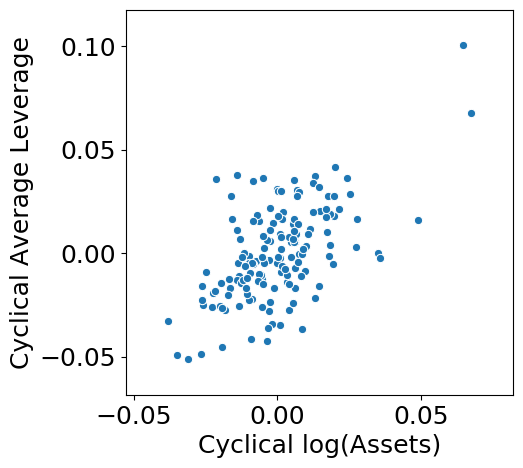

In [12]:
df_agg_liab

#Compute Leverage
df_agg_liab_leverage = df_agg_liab.copy()
df_agg_liab_leverage["leverage"] = df_agg_liab.assets/df_agg_liab.equity

df_agg_liab_leverage_mean = df_agg_liab_leverage.groupby("date").mean()



fig, ax = plt.subplots(figsize=(5,5))

cycle_leverage, trend_all = sm.tsa.filters.hpfilter(np.log(df_agg_liab_leverage_mean.leverage), 1600)

cycle_assets, trend_all = sm.tsa.filters.hpfilter(np.log(df_agg_liab_leverage_mean.assets), 1600)

sns.scatterplot(x=cycle_assets, y=cycle_leverage, ax = ax)

ax.set_ylabel("Cyclical Average Leverage")
ax.set_xlabel("Cyclical log(Assets)")

In [13]:
df_agg_liab_leverage_mean

,year,quarter,rssdid,assets,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab,leverage
date,,,,,,,,,,,,,
1976-03-31,1976.0,1.0,7.380992e+09,1.073635e+09,6.751280e+07,57415924.0,7.619710e+08,1.420878e+08,7.798045e+06,0.0,4659122.0,32190192.0,15.902688
1976-06-30,1976.0,2.0,7.400314e+09,1.105135e+09,6.933909e+07,59634207.0,7.813385e+08,1.453992e+08,8.766644e+06,0.0,5094790.0,35562537.0,15.938123
1976-09-30,1976.0,3.0,7.392513e+09,1.119239e+09,7.088496e+07,64289054.0,7.875529e+08,1.482995e+08,8.820239e+06,0.0,5057128.0,34335681.0,15.789521
1976-12-31,1976.0,4.0,7.409692e+09,1.185900e+09,7.244036e+07,70828210.0,8.296174e+08,1.640299e+08,9.895570e+06,0.0,5284293.0,33804637.0,16.370713
1977-03-31,1977.0,1.0,7.398205e+09,1.189848e+09,7.382384e+07,73920160.0,8.256761e+08,1.641567e+08,9.807317e+06,0.0,5264563.0,37199022.0,16.117391
1977-06-30,1977.0,2.0,7.418879e+09,1.232257e+09,7.586728e+07,76841845.0,8.517403e+08,1.721184e+08,1.198494e+07,0.0,5521451.0,38182517.0,16.242269
1977-09-30,1977.0,3.0,7.398497e+09,1.267541e+09,7.786532e+07,80696101.0,8.645183e+08,1.845826e+08,1.332303e+07,0.0,5572838.0,40983329.0,16.278640
1977-12-31,1977.0,4.0,7.396260e+09,1.342907e+09,7.945901e+07,84131901.0,9.270863e+08,1.907582e+08,1.361215e+07,0.0,5904691.0,41954411.0,16.900623
1978-03-31,1978.0,1.0,7.373350e+09,1.342715e+09,8.117283e+07,90480039.0,9.118888e+08,1.959646e+08,1.379904e+07,0.0,5854394.0,43555471.0,16.541435


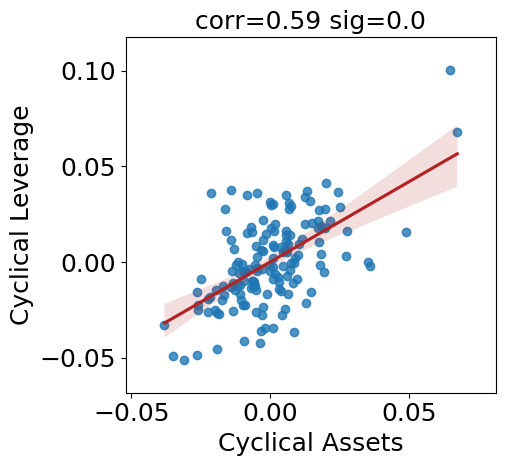

In [22]:
df_agg_liab_leverage_sum = df_agg_liab_leverage.groupby("date").sum()



fig, ax = plt.subplots(figsize=(5.4,5))

cycle_leverage, trend_all = sm.tsa.filters.hpfilter(np.log(df_agg_liab_leverage_sum.leverage), 1600)

cycle_assets, trend_all = sm.tsa.filters.hpfilter(np.log(df_agg_liab_leverage_sum.assets), 1600)

sns.regplot(x=cycle_assets, y=cycle_leverage,line_kws={"color":'firebrick'}, ax=ax)

ax.set_ylabel("Cyclical Leverage")
ax.set_xlabel("Cyclical Assets")

tuple_corr = scipy.pearsonr(cycle_leverage, cycle_assets)
    
ax.set_title("corr=" + str(tuple_corr[0].round(2)) + " sig=" + str(tuple_corr[1].round(3)))

cycle_assets.corr(cycle_leverage)

plt.tight_layout()

plt.savefig('LatexVorlage/graphs/DescriptiveStats/LeverageCylicality_ScatterAggregateLeveragevsAggregateAssets_7613.png')

In [ ]:
df_agg_liab_leverage_sum

Correlation between cyclical every ten year for aggregated leverage

In [ ]:
df_agg_liab_leverage_sum

In [ ]:
import scipy.stats as scipy

temp_df = df_agg_liab_leverage_sum.copy()

temp_df["leverage"] = temp_df["assets"] / temp_df["equity"]

year_begin = 1980

corr_per_range = []

array_correlations = []

for i in range(3):
    #temp = df_agg_liab_leverage_sum
    
    #get range
    leverage_range = temp_df[(temp_df.index > str(year_begin)) & (temp_df.index < str(year_begin+10))].leverage
    asset_range = temp_df[(temp_df.index > str(year_begin)) & (temp_df.index < str(year_begin+10))].assets
    
    #compute cycle for range
    cycle_leverage, trend_all = sm.tsa.filters.hpfilter(np.log(leverage_range), 1600)
    cycle_assets, trend_all = sm.tsa.filters.hpfilter(np.log(asset_range), 1600)
    
    #add corr per range to array
    corr = scipy.pearsonr(cycle_leverage, cycle_assets)
    
    #round tuple numbers
    
    #corr_per_range.append(tuple(map(lambda x: isinstance(x, float) 
                                    #and round(x, 2) or x, corr_per_range[i] )))
    corr_per_range.append(tuple(round(x,2) for x in corr))
    
    #round(2,corr_per_range[i])
    
    
    #for j in range(len(corr_per_range[i])):
    #    corr_per_range[i][j] = corr_per_range[i][j].round(2)
    
    #increment range year
    year_begin += 10



In [ ]:
corr_per_range

array_correlations = []
array_significance = []

for value in corr_per_range:
    array_correlations.append(value[0])
    
for value in corr_per_range:
    array_significance.append(value[1])

In [ ]:
year = 1000

print(str(year))

type(year)

In [ ]:
array_ranges = ["1980-1990", "1990-2000", "2000-2010"]

df_ten_years = pd.DataFrame({"year_range" : array_ranges, "correlation" : array_correlations, "significance" : array_significance })

df_ten_years.set_index("year_range")

df_ten_years.to_latex("LatexVorlage/graphs/Tables/LatexTables/corr_agg_range.tex")

Average cyclical leverage growth vs average cylical asset growth

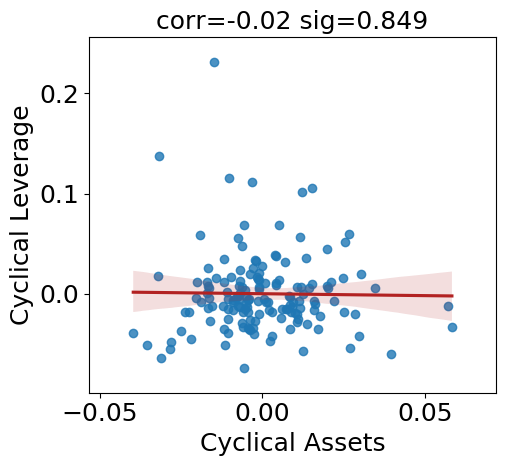

In [16]:
fig, ax = plt.subplots(figsize=(5.4,5))

df_nobhc = df_liab.copy()

df_nobhc["leverage"] = df_nobhc.assets / df_nobhc.equity

df_nobhc.leverage.replace([np.inf, -np.inf], np.nan, inplace=True)
df_nobhc.dropna(how="all", subset=["leverage"], inplace=True)

df_nobhc = df_nobhc[df_nobhc.leverage > 0]

df_nobhc_mean = df_nobhc.groupby(["year", "quarter"]).mean()
df_nobhc_sum = df_nobhc.groupby(["year", "quarter"]).sum()


cycle_leverage, trend_all = sm.tsa.filters.hpfilter(np.log(df_nobhc_mean.leverage), 1600)
cycle_assets, trend_all = sm.tsa.filters.hpfilter(np.log(df_nobhc_mean.assets), 1600)
#cycle_temp, trend_temp = sm.tsa.filters.hpfilter(df_all_grouped_mean.leverageRatio["mean"], 1600)
#cycle_all.plot(figsize=(20,5))

#cycle_allbanks.corr(cycle_all)

#cycle_assets, trend_all = sm.tsa.filters.hpfilter(np.log(df_nobhc_sum.assets), 1600)
#cycle_assets_bhc, trend_all = sm.tsa.filters.hpfilter(np.log(df_all_grouped_mean.agg_assets), 1600)

#cycle_assets.corr(cycle_assets_bhc)

cycle_leverage.corr(cycle_assets)

sns.regplot(x=cycle_assets, y=cycle_leverage, ax=ax, line_kws={"color":"firebrick"})

ax.set_ylabel("Cyclical Leverage")
ax.set_xlabel("Cyclical Assets")

tuple_corr = scipy.pearsonr(cycle_leverage, cycle_assets)
    
ax.set_title("corr=" + str(tuple_corr[0].round(2)) + " sig=" + str(tuple_corr[1].round(3)))

plt.tight_layout()

plt.savefig('LatexVorlage/graphs/DescriptiveStats/LeverageCylicality_ScatterAverageLeveragevsAggregateAssets_7613.png')

Correlation between cyclical every ten year for averaged leverage

In [17]:
df_nobhc_mean.index.get_level_values(0) < 2000

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [18]:
year_begin = 1980

corr_per_range = []

array_correlations = []

for i in range(3):
    temp = df_nobhc_mean
    
    #get range
    leverage_range = temp[(df_nobhc_mean.index.get_level_values(0) > year_begin) & (df_nobhc_mean.index.get_level_values(0)< year_begin+10)].leverage
    asset_range = temp[(df_nobhc_mean.index.get_level_values(0) > year_begin) & (df_nobhc_mean.index.get_level_values(0) < year_begin+10)].assets
    
    #compute cycle for range
    cycle_leverage, trend_all = sm.tsa.filters.hpfilter(np.log(leverage_range), 1600)
    cycle_assets, trend_all = sm.tsa.filters.hpfilter(np.log(asset_range), 1600)
    
    #add corr per range to array
    temp = scipy.pearsonr(cycle_leverage, cycle_assets)
    
    #round tuple numbers
    
    #corr_per_range.append(tuple(map(lambda x: isinstance(x, float) 
                                    #and round(x, 2) or x, corr_per_range[i] )))
    corr_per_range.append(tuple(round(x,2) for x in temp))
    
    #round(2,corr_per_range[i])
    
    
    #for j in range(len(corr_per_range[i])):
    #    corr_per_range[i][j] = corr_per_range[i][j].round(2)
    
    #increment range year
    year_begin += 10

In [19]:
corr_per_range

array_correlations = []
array_significance = []

for value in corr_per_range:
    array_correlations.append(value[0])
    
for value in corr_per_range:
    array_significance.append(value[1])

In [20]:
array_ranges = ["1980-1990", "1990-2000", "2000-2010"]

df_ten_years = pd.DataFrame({"year_range" : array_ranges, "correlation" : array_correlations, "significance" : array_significance })

df_ten_years.set_index("year_range")

df_ten_years.to_latex("LatexVorlage/graphs/Tables/LatexTables/corr_average_range.tex")

In [21]:
import statsmodels.api as sm

x = cycle_assets
y = cycle_leverage

x = sm.add_constant(x)

model = sm.OLS(y,x)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         leverage_cycle   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     21.25
Date:                Sun, 17 May 2020   Prob (F-statistic):           5.47e-05
Time:                        17:25:53   Log-Likelihood:                 72.040
No. Observations:                  36   AIC:                            -140.1
Df Residuals:                      34   BIC:                            -136.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.758e-12      0.006   -6.7e-10      1.000      -0.011       0.011
assets_cycle    -1.4055      0.305     -4.610      0.000      -2.025      -0.786
==============================================================================
Omnibus:                       36.102   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.841
Skew:                           2.213   Prob(JB):                     3.49e-27
Kurtosis:                      10.850   Cond. No.                         54.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""